<a href="https://colab.research.google.com/github/anubhavgupta1/Dive-Into-Deep-Learning/blob/main/Softmax%20Regression/Implementation%20from%20Scratch/mxnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Softmax Regression

In [ ]:
!pip install d2l==0.16.1
!pip install -U mxnet-cu101==1.7.0

In [2]:
from d2l import mxnet as d2l
from mxnet import autograd, np, npx, gluon
from IPython import display
npx.set_np()
%matplotlib inline
import sys
d2l.use_svg_display()

### Reading the Dataset

In [ ]:
mnist_train = gluon.data.vision.FashionMNIST(train=True)
mnist_test = gluon.data.vision.FashionMNIST(train=False)

In [4]:
len(mnist_train), len(mnist_test), mnist_train[0][0].shape

(60000, 10000, (28, 28, 1))

In [5]:
def get_fashion_mnist_labels(labels):  #@save
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat','sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [6]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

(18, 28, 28, 1)
(18, 28, 28)


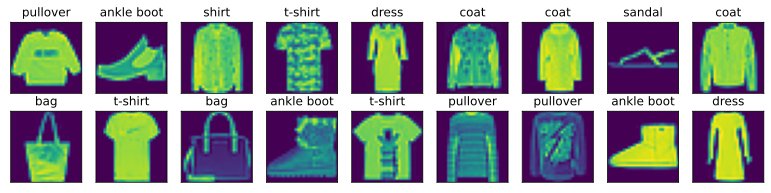

In [7]:
X, y = mnist_train[:18]

print(X.shape)
print(X.squeeze(axis=-1).shape)
show_images(X.squeeze(axis=-1), 2, 9, titles=get_fashion_mnist_labels(y));

### Reading the minibatch

In [8]:
def get_dataloader_workers():  #@save
    """Use 4 processes to read the data except for Windows."""
    return 0 if sys.platform.startswith('win') else 4

In [9]:
batch_size = 256
# `ToTensor` converts the image data from uint8 to 32-bit floating point. It
# divides all numbers by 255 so that all pixel values are between 0 and 1
transformer = gluon.data.vision.transforms.ToTensor()
train_iter = gluon.data.DataLoader(mnist_train.transform_first(transformer),batch_size, shuffle=True,num_workers=get_dataloader_workers())

### Putting All Things Together

In [10]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """Download the Fashion-MNIST dataset and then load it into memory."""
    dataset = gluon.data.vision
    trans = [dataset.transforms.ToTensor()]
    if resize:
        trans.insert(0, dataset.transforms.Resize(resize))
    trans = dataset.transforms.Compose(trans)
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans)
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans)
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers()),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers()))

(18, 1, 28, 28)
(18, 28, 28)


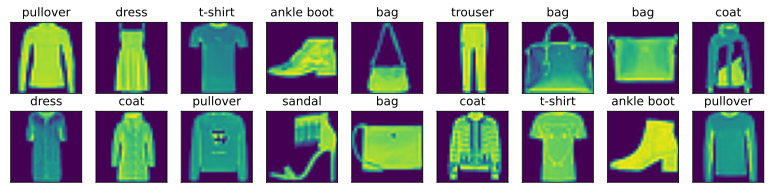

In [11]:
train_iter, test_iter = load_data_fashion_mnist(18)
for X, y in train_iter:
  print(X.shape)
  print(X.squeeze(axis=-3).shape)
  show_images(X.squeeze(axis=-3), 2, 9, titles=get_fashion_mnist_labels(y));
  break;

In [12]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

###Initializing Model Parameters

In [13]:
num_inputs = 784
num_outputs = 10

W = np.random.normal(0, 0.01, (num_inputs, num_outputs))
b = np.zeros(num_outputs)
print("W : \n", W[0])
print("b : \n", b)
W.attach_grad()
b.attach_grad()

W : 
 [ 0.02212206  0.01163079  0.00774004  0.00483805  0.0104344   0.00299563
  0.01183925  0.00153025  0.01891711 -0.01168815]
b : 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Defining the Model

In [14]:
def softmax(X):
    X_exp = np.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # The broadcasting mechanism is applied here

In [15]:
X = np.random.normal(0, 1, (2, 5))
X_prob = softmax(X)
X, X_prob, X_prob.sum(1), X_prob.argmax(axis=1)

(array([[ 0.5030464 , -0.7089397 , -0.72034746,  0.79505837,  0.9336002 ],
        [ 1.0187219 , -1.97108   , -0.15738758, -0.907509  , -1.5379014 ]]),
 array([[0.22376052, 0.06659239, 0.06583703, 0.29964197, 0.3441681 ],
        [0.63209665, 0.03179282, 0.194987  , 0.09209415, 0.04902935]]),
 array([1.        , 0.99999994]),
 array([4, 0], dtype=int64))

In [16]:
def net(X):
    return softmax(np.dot(X.reshape((-1, W.shape[0])), W) + b)

In [17]:
x = [range(0, 2), np.array([1.5, 2. ])]
y = np.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
print(y[range(0, 2),np.array([0, 2. ])])

[0.1 0.5]


### Defining the Loss Function

In [18]:
y = np.array([0, 2])
y_hat = np.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
print(y_hat.shape)
print("\nrange(0,2) = ",range(0,2))
print("\nrange(len(y_hat)) = ",range(len(y_hat)))
print("\n[range(len(y_hat)), y] = ",[range(len(y_hat)), y])
print("\ny_hat[range(0, 2), y] = ",y_hat[range(len(y_hat)), y])
print("\n-np.log(y_hat[range(len(y_hat)), y]) = ", -np.log(y_hat[range(len(y_hat)), y]))

(2, 3)

range(0,2) =  range(0, 2)

range(len(y_hat)) =  range(0, 2)

[range(len(y_hat)), y] =  [range(0, 2), array([0., 2.])]

y_hat[range(0, 2), y] =  [0.1 0.5]

-np.log(y_hat[range(len(y_hat)), y]) =  [2.3025851 0.6931472]


In [19]:
y_hat = np.array([[0.1, 0.9], [0.55, 0.45], [0.3, 0.7], [0.85, 0.15]])
y = np.array([1, 1, 1, 0], dtype=int)
print(y_hat.shape)
print("\nrange(0,2) = ",range(0,2))
print("\nrange(len(y_hat)) = ",range(len(y_hat)))
print("\n[range(len(y_hat)), y] = ",[range(len(y_hat)), y])
print("\ny_hat[range(0, 2), y] = ",y_hat[range(len(y_hat)), y])
print("\n-np.log(y_hat[range(len(y_hat)), y]) = ", -np.log(y_hat[range(len(y_hat)), y]))

(4, 2)

range(0,2) =  range(0, 2)

range(len(y_hat)) =  range(0, 4)

[range(len(y_hat)), y] =  [range(0, 4), array([1, 1, 1, 0], dtype=int64)]

y_hat[range(0, 2), y] =  [0.9  0.45 0.7  0.85]

-np.log(y_hat[range(len(y_hat)), y]) =  [0.10536055 0.79850775 0.35667497 0.1625189 ]


In [20]:
def cross_entropy(y_hat, y):
    return - np.log(y_hat[range(len(y_hat)), y])

### Classification Accuracy

In [21]:
class Accumulator:  #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [22]:
def accuracy(y_hat, y):  #@save
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.astype(y.dtype) == y
    return float(cmp.astype(y.dtype).sum())

In [23]:
def evaluate_accuracy(net, data_iter):  #@save
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for X, y in data_iter:
        y_hat = net(X)
        acc = accuracy(y_hat, y)
        metric.add(acc, y.size)
    return metric[0] / metric[1]

In [24]:
metric = Accumulator(2)
print("metric[0] is : ",metric[0],"\nmetric[1] is : ", metric[1])
for X, y in test_iter:
  y_hat = net(X).argmax(axis=1)
  cmp = y_hat.astype(y.dtype) == y
  cmp_int = cmp.astype(y.dtype)
  print("Data type of y is : ", y.dtype,
        "\nData type of y_hat is : ",y_hat.dtype,
        "\nData type of cmp is : ",cmp.dtype,
        "\nData type of cmp_int is : ",cmp_int.dtype)
  accuracy_ = float(cmp_int.sum())
  metric.add(accuracy_, y.size)
  print("Correct Predictions : ",metric[0],
        "\nTotal Predictions : ",metric[1],
        "\nAverage accuracy is : ",metric[0]/metric[1])
  break;

metric[0] is :  0.0 
metric[1] is :  0.0
Data type of y is :  int32 
Data type of y_hat is :  int64 
Data type of cmp is :  bool 
Data type of cmp_int is :  int32
Correct Predictions :  23.0 
Total Predictions :  256.0 
Average accuracy is :  0.08984375


In [25]:
evaluate_accuracy(net, test_iter)

0.0811

### Training

In [26]:
def sgd(params, lr, batch_size): #@save
    """Minibatch stochastic gradient descent."""
    for param in params:
      param[:] = param - lr * param.grad / batch_size

In [27]:
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

In [28]:
def train_epoch(net, train_iter, loss, updater):  #@save
    """Train a model within one epoch (defined in Chapter 3)."""
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    if isinstance(updater, gluon.Trainer):
        updater = updater.step
    for X, y in train_iter:
        # Compute gradients and update parameters
        with autograd.record():
            y_hat = net(X)
            l = loss(y_hat, y)
        l.backward()
        updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.size)
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [29]:
class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [30]:
def train(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """Train a model (defined in Chapter 3)."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        print("epoch = {epoch}/{epochs}, train loss = {tloss}, train acc = {tacc}, test acc = {tsacc}"
              .format(epoch=epoch+1,epochs=num_epochs, tloss=train_metrics[0],tacc=train_metrics[1], tsacc = test_acc) )
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    print("Training Loss is : ",train_loss)
    print("Training Accuracy is : ",train_acc)
    print("Test Accuracy is : ",test_acc)
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

Training Loss is :  0.45054269507726036
Training Accuracy is :  0.84565
Test Accuracy is :  0.8367


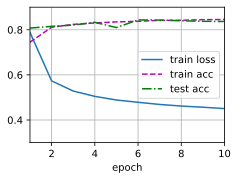

In [31]:
num_epochs = 10
lr = 0.1
train(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [32]:
def predict(net, test_iter, n=6):  #@save
    """Predict labels (defined in Chapter 3)."""
    for X, y in test_iter:
        break
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

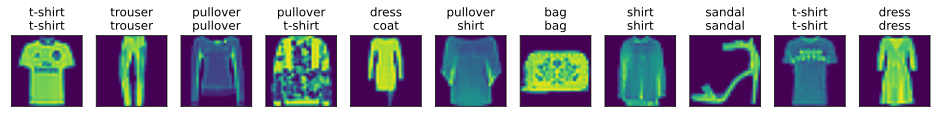

In [33]:
predict(net, test_iter,n=11)